In [ ]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from datetime import datetime
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account("5fe30e6c8e71223b5549d253025a1f141713265617a67216a3f92d3dd3ea08be71b7676a82869b7ad89d2ddcd67a117acaf2e0434f3c525b730f30bb234df6e3", overwrite=True)
provider = IBMProvider()

from QLSTM import SequenceDataset
import yfinance as yf
from pandas_datareader import data as pdr



In [3]:
df = pd.read_csv("final_combined_mutation_dataset.csv")


In [4]:
columns = ['Open', 'High', 'Low', 'Close']

In [ ]:
columns = ['Collection_Year', 'Body_Temperature', 'Parasite_Density']
target = "Mutation_Label"
features = columns

# Include the target column too
df_train = df_train[columns + [target]]
df_test = df_test[columns + [target]]


In [27]:
data = df.filter(columns)
dataset = data.values

In [28]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
# Correctly split original dataframe
df_train = df.iloc[:size].copy()
df_test = df.iloc[size:].copy()

In [29]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [31]:
# Only normalize numeric columns
numeric_cols = ['Collection_Year', 'Body_Temperature', 'Parasite_Density']
target = 'Mutation_Label'

# Normalize only the numeric part
df_train[numeric_cols], min_train, max_train = normalize(df_train[numeric_cols])
df_test[numeric_cols], _, _ = normalize(df_test[numeric_cols], min_train, max_train)


In [32]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 3])
Target shape: torch.Size([1])


In [33]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [34]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [35]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 285


In [36]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 17

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.2713574227318168
Test loss: 0.2668978725125392
Execution time 1094.223421573639
Epoch 1
---------
Train loss: 0.25720428329493317
Test loss: 0.25080257177352905
Execution time 1066.9553756713867
Epoch 2
---------
Train loss: 0.25832155854574274
Test loss: 0.2587172736227512
Execution time 40807.11022543907
Epoch 3
---------
Train loss: 0.2569390098644154
Test loss: 0.25723465606570245
Execution time 1049.8668887615204
Epoch 4
---------
Train loss: 0.2572058658567922
Test loss: 0.2521128682792187
Execution time 1047.1923606395721
Epoch 5
---------
Train loss: 0.2533021967591984
Test loss: 0.2532171596089999
Execution time 1051.28471493721
Epoch 6
---------
Train loss: 0.2553932742774487
Test loss: 0.2605577044685682
Execution time 1043.6107952594757
Epoch 7
---------
Train loss: 0.2549867898012911
Test loss: 0.25323228860894836
Execution time 1037.0227451324463
Epoch 8
---------
Train loss: 0.25436785132757256
Test loss: 0.25243304

KeyboardInterrupt: 

In [37]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

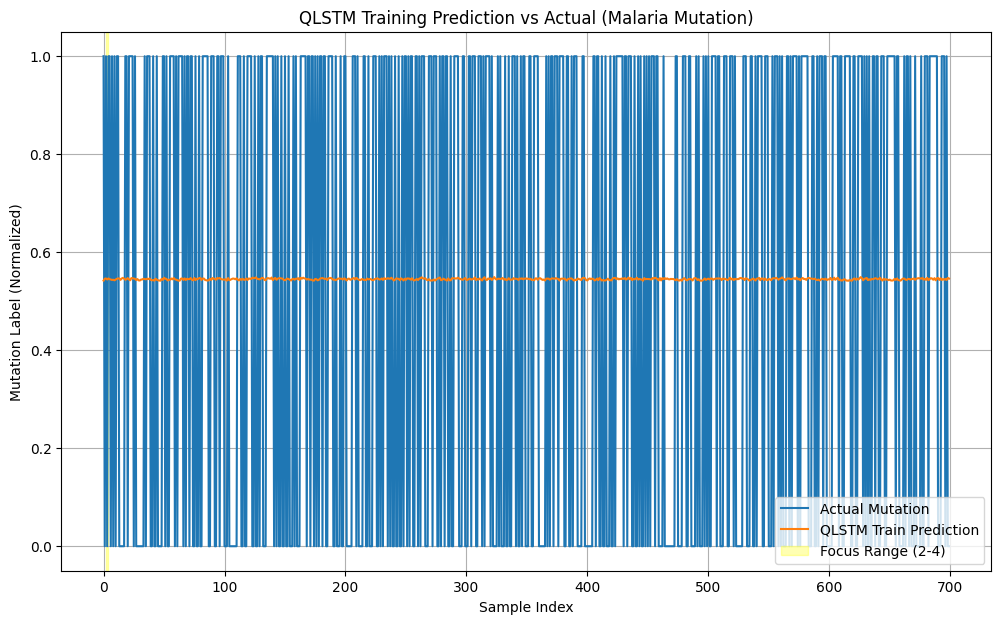

In [39]:
plt.figure(figsize=(12, 7))

# Plot actual and predicted
plt.plot(range(len(df_train)), df_train["Mutation_Label"], label="Actual Mutation")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label="QLSTM Train Prediction")

# Highlight index range from 2 to 4
plt.axvspan(2, 4, color='yellow', alpha=0.3, label="Focus Range (2-4)")

# Labels and grid
plt.ylabel('Mutation Label (Normalized)')
plt.xlabel('Sample Index')
plt.legend()
plt.grid(True)
plt.title("QLSTM Training Prediction vs Actual (Malaria Mutation)")
plt.show()


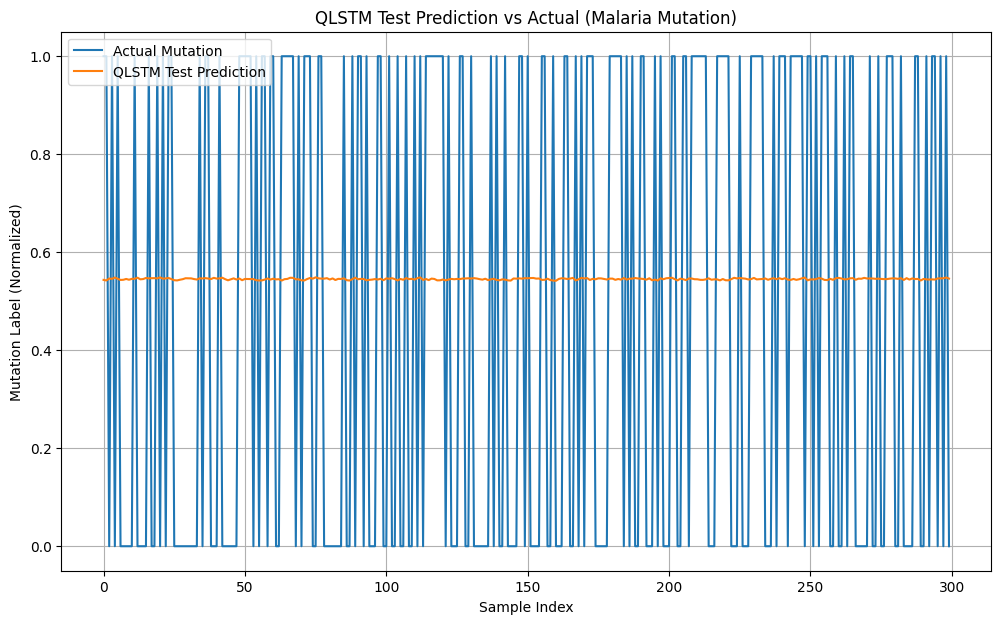

In [40]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["Mutation_Label"], label="Actual Mutation")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label="QLSTM Test Prediction")
plt.ylabel('Mutation Label (Normalized)')
plt.xlabel('Sample Index')
plt.title("QLSTM Test Prediction vs Actual (Malaria Mutation)")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
from sklearn.metrics import mean_squared_error
import math

train_rmse = math.sqrt(mean_squared_error(df_train["Mutation_Label"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["Mutation_Label"], df_test["Model Forecast"]))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.5012115760117142
Test RMSE: 0.5057683148407878


In [43]:
import numpy as np  # Make sure this is included if not already

# Accuracy function with ±0.1 tolerance
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

# Use correct column name for mutation data
train_accuracy = accuracy(df_train["Mutation_Label"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Mutation_Label"], df_test["Model Forecast"])

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Train accuracy: 0.0000
Test accuracy: 0.0000


In [44]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_mutation_Model.pt")

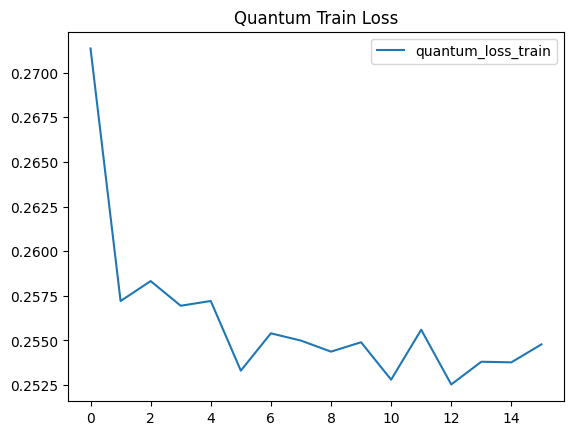

In [45]:
plt.plot(quantum_loss_train, label='quantum_loss_train')
# plt.plot(quantum_loss_test, label='quantum_loss_test')  # Uncomment if you have test loss
pd.DataFrame(quantum_loss_train).to_csv('QLSTM_loss.csv', index=False)
plt.title('Quantum Train Loss')
plt.legend()
plt.show()


In [50]:
from QLSTM import QLSTM  # or from your own definition

input_dim = 3          # Encoded_Sequence, Geo_Location, Body_Temperature
hidden_dim = 32
num_layers = 1
output_dim = 1

quantum_model = QLSTM(input_dim, hidden_dim, num_layers, output_dim)


weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 1)


In [51]:
torch.save(quantum_model.state_dict(), "quantum_model.pth")


In [52]:
quantum_model.load_state_dict(torch.load("quantum_model.pth"))
quantum_model.eval()


QLSTM(
  (clayer_in): Linear(in_features=35, out_features=1, bias=True)
  (clayer_out): Linear(in_features=1, out_features=32, bias=True)
)

In [62]:
# In the quantum model (QLSTM)
def forward(self, x, init_states=None):
    # Check shape of x here to ensure it's as expected
    print(x.shape)

    # Ensure quantum gates do not use the same wire for control and target operations
    # For example, if using PennyLane or a similar framework, check this:
    # qml.CNOT(wires=[control_wire, target_wire])  # Ensure control and target are different
    # Adjust quantum gates to ensure no conflict with wires

    # Continue with quantum operations here...
    # Make sure the quantum layers are properly designed to handle the input


In [73]:
print(globals().keys())


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'pd', 'time', 'np', 'math', 'plt', 'torch', 'DataLoader', 'nn', 'datetime', 'IBMProvider', 'provider', 'SequenceDataset', 'yf', 'pdr', '_i2', '_i3', 'df', '_i4', 'columns', '_i5', 'data', 'dataset', '_i6', 'size', 'df_train', 'df_test', '_i7', 'target', 'features', '_i8', '_i9', 'normalize', '_i10', 'min_train', 'max_train', '_i11', 'batch_size', 'sequence_length', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i30', '_i31', 'numeric_cols', '_i32', 'train_dataset', 'test_dataset', 'train_loader', 'test_loader', 'X', 'y', '_i33', 'train_model', 'test_model', 'predict', '_i34', 'QShallowRegressionLSTM', 'learning_rate', 'num_hidden_units', 'Qmodel'

In [74]:
# Predict using test_eval_loader
quantum_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_eval_loader:
        y_pred = quantum_model(X_batch)
        predictions.extend(y_pred.detach().cpu().numpy().flatten())
        actuals.extend(y_batch.detach().cpu().numpy().flatten())

# Save predictions and actuals to CSV
import pandas as pd
df_result = pd.DataFrame({
    'Actual': actuals,
    'Predicted': predictions
})
df_result.to_csv('qlstm_mutation_predictions.csv', index=False)
print("Predictions saved to 'qlstm_mutation_predictions.csv'")


ValueError: The control wires must be different from the base operation wires.